In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import random
import string
import tensorflow as tf
from tensorflow.python.ops.rnn_cell import _linear
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import collections
import matplotlib.pyplot as plt
import codecs
import time
import os
import gc
from six.moves import cPickle as pickle

from plot_module import text_plot
from plot_module import structure_vocabulary_plots
from plot_module import ComparePlots

from model_module import maybe_download
from model_module import read_data
from model_module import check_not_one_byte
from model_module import id2char
from model_module import char2id
from model_module import BatchGenerator
from model_module import characters
from model_module import batches2string
from model_module import logprob
from model_module import sample_distribution
from model_module import MODEL

In [7]:
if not os.path.exists('enwik8_filtered'):
    if not os.path.exists('enwik8'):
        filename = maybe_download('enwik8.zip', 36445475)
    full_text = read_data(filename)
    new_text = u""
    new_text_list = list()
    for i in range(len(full_text)):
        if (i+1) % 10000000 == 0:
            print("%s characters are filtered" % i)
        if ord(full_text[i]) < 256:
            new_text_list.append(full_text[i])
    text = new_text.join(new_text_list)
    del new_text_list
    del new_text
    del full_text

    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)
    
    f = open('enwik8_filtered', 'w')
    f.write(text.encode('utf8'))
    f.close()
    
else:
    f = open('enwik8_filtered', 'r')
    text = f.read().decode('utf8')
    f.close() 
    (not_one_byte_counter, min_character_order_index, max_character_order_index, number_of_characters, present_characters_indices) = check_not_one_byte(text)

    print("number of not one byte characters: ", not_one_byte_counter) 
    print("min order index: ", min_character_order_index)
    print("max order index: ", max_character_order_index)
    print("total number of characters: ", number_of_characters)    

number of not one byte characters:  0
min order index:  9
max order index:  255
total number of characters:  196


In [8]:
#different
offset_1 = 0
offset_2 = 4100
valid_size_1 = 4000
valid_size_2 = 4000
valid_text_1 = text[offset_1:offset_1+valid_size_1]
valid_text_2 = text[offset_2:offset_2+valid_size_2]
train_text = text[offset_2+valid_size_2:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size_1, valid_text_1[:64])
print(valid_size_2, valid_text_2[:64])
print(valid_text_1)
print('\n\n\n')
print(valid_text_2)

99371900 , Zeno &quot;repudiated the omnipotence of the state, its interv
4000 <mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmln
4000 reserve">{{Anarchism}}
'''Anarchism''' originated as a term of a
<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.3/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd" version="0.3" xml:lang="en">
  <siteinfo>
    <sitename>Wikipedia</sitename>
    <base>http://en.wikipedia.org/wiki/Main_Page</base>
    <generator>MediaWiki 1.6alpha</generator>
    <case>first-letter</case>
      <namespaces>
      <namespace key="-2">Media</namespace>
      <namespace key="-1">Special</namespace>
      <namespace key="0" />
      <namespace key="1">Talk</namespace>
      <namespace key="2">User</namespace>
      <namespace key="3">User talk</namespace>
      <namespace key="4">Wikipedia</namespace>
      <namespace key="5">Wikipedia talk</n

In [21]:
#different
offset = 12000
valid_size = 25000
valid_text = text[offset:offset+valid_size]
train_text = text[offset+valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99343000 ves feminists, and anarcha-feminist ideas are growing.  The publ
25000 accordance with principles of equality and justice. 

Proudhon's


In [10]:
vocabulary_size = number_of_characters
vocabulary = list()
characters_positions_in_vocabulary = list()

character_position_in_vocabulary = 0
for i in range(256):
    if present_characters_indices[i]:
        vocabulary.append(unichr(i))
        characters_positions_in_vocabulary.append(character_position_in_vocabulary)
        character_position_in_vocabulary += 1
    else:
        characters_positions_in_vocabulary.append(-1)


string_vocabulary = u""
for i in range(vocabulary_size):
    string_vocabulary += vocabulary[i]
print("Vocabulary: ", string_vocabulary)
print("char2id(u'a') = %s,  char2id(u'z') = %s,  char2id(u' ') = %s" % (char2id(u'a', characters_positions_in_vocabulary),
                                                                        char2id(u'z', characters_positions_in_vocabulary),
                                                                        char2id(u' ', characters_positions_in_vocabulary)))
print("id2char(78) = %s,  id2char(156) = %s,  id2char(140) = %s" % (id2char(78,
                                                                            vocabulary),
                                                                    id2char(156,
                                                                            vocabulary),
                                                                    id2char(140,
                                                                            vocabulary)))


Vocabulary:  	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÀÁÂÃÄÅÆÇÈÉÊËÌÍÎÏÐÑÒÓÔÕÖ×ØÙÚÛÜÝÞßàáâãäåæçèéêëìíîïðñòóôõö÷øùúûüýþÿ
char2id(u'a') = 67,  char2id(u'z') = 92,  char2id(u' ') = 2
id2char(78) = l,  id2char(156) = Ø,  id2char(140) = È


In [11]:
batch_size_test=64
num_unrollings_test=10

train_batches_test = BatchGenerator(train_text,
                                    batch_size_test,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    num_unrollings_test)
valid_batches_test = BatchGenerator(valid_text_1,
                                    1,
                                    vocabulary_size,
                                    characters_positions_in_vocabulary,
                                    1)

print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(train_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))
print(batches2string(valid_batches_test.next(), vocabulary))

[u'nists]] suc', u', the word ', u'nt>\n      <', u'ile neoclas', u'Arminius ta', u'laric I tak', u'uld be used', u'orgeries wr', u'NR) ratios ', u'onstituency', u'l-Intercept', u'upporting t', u" ''Doorgame", u'\n[[Sodium b', u'[Gadianton ', u' always pos', u'ence paid o', u' from the l', u'al, it was ', u"lizzard's [", u' is a subse', u'uro Alessan', u' upon enter', u' Caesar, fo', u"he nation's", u' inaugurate', u'|\nyear=2004', u"onicle's cl", u"'Mrs. Warre", u'e Just.  Dr', u'1989, the F', u'South India', u'sh:\n- rhoti', u'8 december]', u'ct, [[Recoi', u'ril 2003: D', u'raadelst.bh', u'ed the resu', u'ad created ', u'eans that p', u'es Wide Shu', u'al knowledg', u'ot describe', u'ged, includ', u't;1&lt;/sub', u"'' issue da", u'/&gt; [[Bra', u'escribed as', u'the [[Greek', u'humb|Waterf', u'es of the G', u'he Azerbaij', u'medieval [[', u'nter-Reform', u'in the audi', u' [[1390]] h', u' government', u'of Parliame', u' comprise t', u'ss. With th', u'erves as an', u'\n**[[IUPUI|', u'

In [12]:

class ACT_LSTM(MODEL):
    
    def LSTM_cell(self, inp, state):
        X = tf.concat(1, [inp,
                          state[0]])
        concat = tf.matmul(X, self.Matrix) + self.Bias
        [i, f, o, g] = tf.split(1, 4, concat)
        i = tf.sigmoid(i)
        f = tf.sigmoid(f)
        o = tf.sigmoid(o)
        g = tf.tanh(g)
        new_state = tf.tanh(i*g+f*state[1])
        output = o * new_state 
        return [output, new_state]
    
    def add_flag_to_input(self, X, idx):
        flags = list()
        one_flag = [0.]*self._depth
        one_flag[idx] = 1.
        flag = tf.pack([tf.constant(one_flag)] * X.get_shape().as_list()[0])
        return tf.concat(1, [X, flag])
    
    def compute_halting_units(self, intermediate_states):
        states_concat = tf.concat(0, [tf.concat(1, [state[0], state[1]]) for state in intermediate_states])
        halting_units = tf.sigmoid(tf.matmul(states_concat, self.Halting_Matrix) + self.Halting_Bias)
        return tf.split(0, len(intermediate_states), halting_units)
    
    def compute_probabilities(self, halting_units):
        b_size = halting_units[0].get_shape().as_list()[0]
        agregate = tf.zeros([b_size, 1])
        completed = tf.zeros([b_size, 1])
        ones = tf.ones([b_size, 1])
        minus_ones = - ones
        probabilities = list()
        prob_loss = 0
        for idx, halting_unit in enumerate(halting_units):
            if idx == self._depth - 1:
                completed_flags = tf.to_float(tf.greater(agregate, -0.5))
            else:
                completed_flags = tf.to_float(tf.greater(agregate + halting_unit, self._threshold))
            completed += completed_flags
            probabilities.append((ones - completed) * halting_unit + completed_flags * (ones - agregate))
            prob_loss += tf.reduce_sum(completed_flags * (ones - agregate))
            agregate = minus_ones * completed + (ones - completed) * (agregate + halting_unit)
        return probabilities, prob_loss
            
    def compute_number_of_iterations(self, probabilities):
        probs = tf.concat(1, probabilities)
        looped = tf.greater(probs, 0)
        looped = tf.to_int32(looped)
        return tf.reduce_sum(looped, reduction_indices=[1])
               
    
    def iteration(self, inp, state):
        intermediate_states = list()
        for idx in range(self._depth):
            state = self.LSTM_cell(self.add_flag_to_input(inp, idx), state)
            intermediate_states.append(state)
        halting_units = self.compute_halting_units(intermediate_states)
        probabilities, prob_loss = self.compute_probabilities(halting_units)
        number_of_iterations = self.compute_number_of_iterations(probabilities)
        new_state = [0, 0]
        for inter_state, probability in zip(intermediate_states, probabilities):
            new_state[0] +=  inter_state[0] * probability
            new_state[1] +=  inter_state[1] * probability
        return new_state[0], new_state, prob_loss, number_of_iterations, probabilities, halting_units

    
    def __init__(self,
                 batch_size,
                 vocabulary,
                 characters_positions_in_vocabulary,
                 num_unrollings,
                 num_nodes,
                 depth,
                 indent,
                 time_penalty,
                 train_text,
                 valid_text,
                 mean=0.,
                 stddev='default',
                 shift=0.,
                 init_learning_rate=5.):
        self._results = list()
        self._batch_size = batch_size
        self._vocabulary = vocabulary
        self._vocabulary_size = len(vocabulary)
        self._characters_positions_in_vocabulary = characters_positions_in_vocabulary
        
        self._num_unrollings = num_unrollings

        self._num_layers = 1
        self._num_nodes = num_nodes
        self._depth = depth
        self._indent = indent
        self._time_penalty = time_penalty
        self._threshold = 1. - indent
        self._train_text = train_text
        self._valid_text = valid_text
        if isinstance(self._valid_text, dict):
            keys = self._valid_text.keys()
            self._valid_size = dict([zipped for zipped in zip(keys, [len(self._valid_text[key]) for key in keys])])
        else:
            self._valid_size = len(valid_text)
        
        
        self._mean = mean
        
        self._shift = shift
        
        self._stddev = list()
        if stddev == 'default':
            self._stddev = 1.4
        else:
            self._stddev = stddev

        self._init_learning_rate = init_learning_rate
  
        self._indices = {"batch_size": 0,
                         "num_unrollings": 1,
                         "num_layers": 2,
                         "num_nodes": 3,
                         "depth": 4,
                         "indent": 5,
                         "time_penalty": 6,
                         "half_life": 7,
                         "decay": 8,
                         "num_steps": 9,
                         "averaging_number": 10,
                         "init_mean": 11,
                         "init_stddev": 12,
                         "init_shift": 13,
                         "init_learning_rate": 14,                         
                         "type": 15}
        self._graph = tf.Graph()
        
        self._last_num_steps = 0
        with self._graph.as_default(): 
            with self._graph.device('/gpu:0'): 
                self.Matrix = tf.Variable(tf.truncated_normal([self._vocabulary_size + self._num_nodes[0] + self._depth,
                                                                      4 * self._num_nodes[0]],
                                                                     mean=self._mean, stddev=self._stddev / (self._vocabulary_size + self._num_nodes[0] + self._depth)**0.5))
                self.Bias = tf.Variable(tf.zeros([4 * self._num_nodes[0]]))
                
                self.Halting_Matrix = tf.Variable(tf.truncated_normal([2 * self._num_nodes[0],
                                                                      1],
                                                                     mean=self._mean, stddev=self._stddev / self._num_nodes[0]**0.5))
                
                self.Halting_Bias = tf.Variable([[self._shift]])
                # classifier 
                weights = tf.Variable(tf.truncated_normal([self._num_nodes[-1], self._vocabulary_size], stddev = self._stddev / self._num_nodes[-1]**0.5))
                bias = tf.Variable(tf.zeros([self._vocabulary_size]))
                
                """PLACEHOLDERS train data"""
                self._train_data = list()
                for _ in range(self._num_unrollings + 1):
                    self._train_data.append(
                        tf.placeholder(tf.float32, shape=[self._batch_size, self._vocabulary_size]))
                    
                    
                train_inputs = self._train_data[: self._num_unrollings]
                train_labels = self._train_data[1:]  # labels are inputs shifted by one time step.
                # Unrolled LSTM loop.
                
                """global step"""
                self._global_step = tf.Variable(0, trainable=False)

                saved_state = list()
                saved_state.append(tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False))
                saved_state.append(tf.Variable(tf.zeros([self._batch_size, self._num_nodes[0]]), trainable=False))

                outputs = list()
                state = saved_state
                self.number_of_iterations = list()
                first_inputs = list()
                first_outputs = list()
                for i in train_inputs:
                    output, state, prob_loss, number_of_iterations, _, _ = self.iteration(i, state)
                    self.number_of_iterations.append(tf.unpack(number_of_iterations)[0])
                    outputs.append(output)
                    first_inputs.append(tf.split(0, self._batch_size, i)[0])
                    first_outputs.append(tf.split(0, self._batch_size, output)[0])
                self.first_inputs = tf.concat(0, first_inputs)
                self.first_outputs = tf.nn.softmax(tf.nn.xw_plus_b(tf.concat(0, first_outputs), weights, bias))
                self.number_of_iterations = tf.pack(self.number_of_iterations)    

                save_list = list()
                save_list.append(saved_state[0].assign(state[0]))
                save_list.append(saved_state[1].assign(state[1]))
                
                """skip operation"""
                self._skip_operation = tf.group(*save_list)

                with tf.control_dependencies(save_list):
                        # Classifier.
                    logits = tf.nn.xw_plus_b(tf.concat(0, outputs), weights, bias)
                    """loss"""
                    self._loss = tf.reduce_mean(
                        tf.nn.softmax_cross_entropy_with_logits(
                        logits, tf.concat(0, train_labels))) + self._time_penalty * prob_loss

                # Optimizer.
                
                """PLACEHOLDERS half life and decay"""
                self._half_life = tf.placeholder(tf.int32)
                self._decay = tf.placeholder(tf.float32)
                """learning rate"""
                self._learning_rate = tf.train.exponential_decay(self._init_learning_rate,
                                                                 self._global_step,
                                                                 self._half_life,
                                                                 self._decay,
                                                                 staircase=True)
                optimizer = tf.train.GradientDescentOptimizer(self._learning_rate)
                gradients, v = zip(*optimizer.compute_gradients(self._loss))
                gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
                """optimizer"""
                self._optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=self._global_step)
                """train prediction"""
                self._train_prediction = tf.nn.softmax(logits)


                # Sampling and validation eval: batch 1, no unrolling.
                # Sampling and validation eval: batch 1, no unrolling.
                saved_sample_state = list()
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False))
                saved_sample_state.append(tf.Variable(tf.zeros([1, self._num_nodes[0]]), trainable=False)) 
                """PLACEHOLDER sample input"""
                self._sample_input = tf.placeholder(tf.float32, shape=[1, self._vocabulary_size])

                reset_list = list()
                reset_list.append(saved_sample_state[0].assign(tf.zeros([1, self._num_nodes[0]])))
                reset_list.append(saved_sample_state[1].assign(tf.zeros([1, self._num_nodes[0]])))

                """reset sample state"""
                self._reset_sample_state = tf.group(*reset_list)

                sample_output, sample_state, _, self.num_iter, self.probs, hu = self.iteration(self._sample_input, saved_sample_state)

                self.halting_units = tf.concat(1, hu)
                sample_save_list = list()
                sample_save_list.append(saved_sample_state[0].assign(sample_state[0]))
                sample_save_list.append(saved_sample_state[1].assign(sample_state[1]))

                with tf.control_dependencies(sample_save_list):
                    """sample prediction"""
                    self._sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, weights, bias)) 
                
                
                """saver"""
                self.saver = tf.train.Saver(max_to_keep=None)
                            
                        
    
    def _generate_metadata(self, half_life, decay, num_averaging_iterations):
        metadata = list()
        metadata.append(self._batch_size)
        metadata.append(self._num_unrollings)   
        metadata.append(self._num_layers)
        metadata.append(self._num_nodes)
        metadata.append(self._depth)
        metadata.append(self._indent)
        metadata.append(self._time_penalty)
        metadata.append(half_life)
        metadata.append(decay)
        metadata.append(self._last_num_steps)
        metadata.append(num_averaging_iterations)
        metadata.append(self._mean)
        metadata.append(self._stddev)
        metadata.append(self._shift)
        metadata.append(self._init_learning_rate)
        metadata.append('ACT_LSTM')
        return metadata


    def get_iterations(self, session, num_strings=10, length=75, start_positions=None):
        self._reset_sample_state.run()
        self._valid_batches = BatchGenerator(self._valid_text,
                                             1,
                                             self._vocabulary_size,
                                             self._characters_positions_in_vocabulary,
                                             1)
        if start_positions is None:
            start_positions = list()
            if self._valid_size / num_strings < length:
                num_strings = self._valid_size / length
            for i in range(num_strings):
                start_positions.append(i* (self._valid_size / num_strings) + self._valid_size / num_strings / 2)
            while self._valid_size - start_positions[-1] < length:
                del start_positions[-1]
        text_list = list()
        iterations_list = list()
        collect_iterations = False
        letters_parsed = -1
        for idx in range(self._valid_size):
            b = self._valid_batches.next()
            
            if idx in start_positions or collect_iterations: 
                if letters_parsed == -1:
                    letters_parsed = 0
                    text = u""
                    i_list = list()
                    collect_iterations = True
                text += characters(b[0], self._vocabulary)[0]
                i_list.append(self.num_iter.eval({self._sample_input: b[0]})[0])
                letters_parsed += 1
                if letters_parsed >= length:
                    collect_iterations = False
                    iterations_list.append(i_list)
                    text_list.append(text)
                    letters_parsed = -1
                    
            _ = self._sample_prediction.eval({self._sample_input: b[0]})
        return text_list, iterations_list 

In [17]:
model = ACT_LSTM(64,
            vocabulary,
            characters_positions_in_vocabulary,
            10,
            [128],
                    5,
                    0.01,
                    0.001,
            train_text,
            {'html': valid_text_1, 'text': valid_text_2},
            init_learning_rate=0.5)

In [24]:
print_steps = [200 * i for i in range(200)]
model.run(10,
          0.9,
            200,
            50,
            3,
            1,
            100,
          #add_operations = ['self.number_of_iterations'],
          add_text_operations=['self.first_inputs', 'self.first_outputs'],
          print_steps = print_steps,
           #validation_add_operations=['self.num_iter', 'self.probs', 'self.halting_units'],
          #validation_add_operations=['self.num_iter'],
          #num_validation_prints=10,
            print_intermediate_results = True,
          validation_example_length=10)

Initialized
step: 0
self.first_inputs: 
</contribu
self.first_outputs: 
0 7ªR©.+È¿
Average loss at step 0: 5.281536 learning rate: 0.500000
Percentage_of correct: 0.00%

random:
ÊÈ*Ä=>|9.`ó\Á6êïYËÑîO@ìuñ#ç
ëÈL¢Ü:ù1wOU×·ÏîHO|¡ÒNô|´3]úß¸P-D
ºA/Q[¹GjbIºõF?ïØô=M
Eº{+´H½FS-®ôÝSëy=²ÃÞtÃð*ì:2 wÝcxHï8òU-¤+fníËò)Öú¨ùS 'd{s&eâNhúøµCÎ»ó}×ïÛ/yrr]ó¸%
<`}ÿÔûÝ£ÿÏ'Í
HV(<^<±a¥rqW[ÑJbÂnüÑï0¼²aìôÖÑÝ(ùGx9ÏÈ±Ìd·s³ßÀH£]A| jeø3lÅÖÙÏpdëKã
Lár;áÿI;è³vÐ }CãÙý¯Q%Àu`ú¼{Ñ¢êÒèû áQUõ¾ÈÀjvPµë#çA â=¬ÒWý-IP ±j)>T<ÀþsPòYÂ@{ë%¬ZÒ
U[iÊ"mçµÅkN¼Ó·í@PaDâ½8XDsp85Þ^#_MùO$QÝuæK(Ïémx%i{}±õfî½ë¥^ü°xåz­	þ¶~NëÉ8·C¤§ß¤Ù


KeyboardInterrupt: 

In [9]:

sttdev_values = [0.01, 0.05, 0.2, 1., 5., 10., 20., 50., 100.]
init_learning_rate_values = [25., 15., 10., 5., 2., 1., .5, .2, .1, .05]
adjustment_results = list()
for learning_rate in init_learning_rate_values:
    print(' '*10, 'learning_rate:', learning_rate)
    for stddev_value in sttdev_values:
        print(' '*5, 'stddev:', stddev_value)
        model = ACT_LSTM(64,
                         vocabulary,
                         characters_positions_in_vocabulary,
                         10,
                         [128],
                         5,
                         0.01,
                         0.001,
                         train_text,
                         valid_text_1,
                         stddev=stddev_value,
                         init_learning_rate=learning_rate) 
        model.simple_run(200,
                         'ACT_LSTM/variables/adjustment_nl1_nn128/ilr%s_stddev%s' % (learning_rate, stddev_value),
                         5000,
                         250,
                         5000,        #learning has a chance to be stopped after every block of steps
                         10,
                         0.9,
                         3,
                         fixed_num_steps=True) 
        adjustment_results.extend(model._results)
        model.destroy()
        del model
        gc.collect()

           learning_rate: 25.0
      stddev: 0.01
Number of steps = 5000     Percentage = 43.11%     Time = 583s     Learning rate = 8.7170
      stddev: 0.05
Number of steps = 5000     Percentage = 13.44%     Time = 579s     Learning rate = 8.7170
      stddev: 0.2
Number of steps = 5000     Percentage = 13.44%     Time = 582s     Learning rate = 8.7170
      stddev: 1.0
Number of steps = 5000     Percentage = 44.56%     Time = 579s     Learning rate = 8.7170
      stddev: 5.0
Number of steps = 5000     Percentage = 13.44%     Time = 574s     Learning rate = 8.7170
      stddev: 10.0
Number of steps = 5000     Percentage = 13.44%     Time = 370s     Learning rate = 8.7170
      stddev: 20.0
Number of steps = 5000     Percentage = 13.44%     Time = 571s     Learning rate = 8.7170
      stddev: 50.0
Number of steps = 5000     Percentage = 13.44%     Time = 557s     Learning rate = 8.7170
      stddev: 100.0
Number of steps = 5000     Percentage = 13.44%     Time = 583s     Learning rate

In [10]:
folder_name = 'ACT_LSTM'
file_name = 'ACT_LSTM_adjustment_ns_5000_hl_500_dc_0.9_nu_10_ilr15_.05_std0.001-1.pickle'
force = True
pickle_dump = {'adjustment_results': adjustment_results}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_LSTM/ACT_LSTM_adjustment_ns_5000_hl_500_dc_0.9_nu_10_ilr15_.05_std0.001-1.pickle.


In [13]:
from plot_module import ComparePlots

adjustment_plots = ComparePlots('ACT_LSTM')
adjustment_plots.add_network(adjustment_results, model._indices)

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


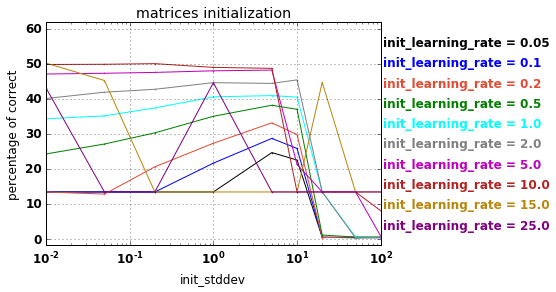

In [14]:
plot_options = {'x': 'log'}
plot_data, _ = adjustment_plots.one_key_layout_data('ACT_LSTM_1',
                                                                'init_stddev',
                                         "init_learning_rate")
adjustment_plots.save_layout(plot_data[0],
                    'matrices initialization',
                    ['adjustment'],
                    'matrices_initialization_nn128;ns5000;hl500;dc0.9',
                     plot_options=plot_options)
adjustment_plots.draw(plot_data[0], 'matrices initialization', plot_options=plot_options)

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


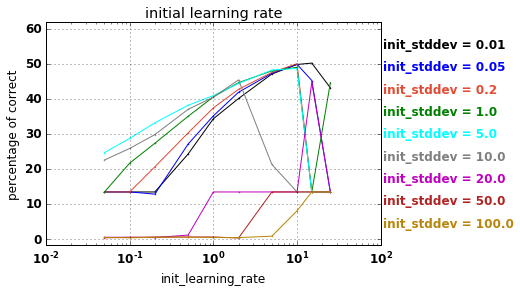

In [15]:
plot_options = {'x': 'log'}
plot_data, _ = adjustment_plots.one_key_layout_data('ACT_LSTM_1',
                                                             "init_learning_rate",
                                                            'init_stddev')
adjustment_plots.save_layout(plot_data[0],
                    'initial learning rate',
                    ['adjustment'],
                    'init_learning_rate_nn128;ns5000;hl500;dc0.9',
                     plot_options=plot_options)
adjustment_plots.draw(plot_data[0], 'initial learning rate', plot_options=plot_options)

In [14]:

num_unrollings_value = 20
indent_values = [.5, .25, .1, .03, .01, .003, .001]
time_penalty_values = [.1, .03, .01, 0.003, .001, 0.0003, 0.0001, .00003, .00001, .000003, .000001, .0]
results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_LSTM(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text_2)
        model.simple_run(100,
                                       'ACT_LSTM/variables/nn128_dth_5_nu20_bs64_ilr5_hl1333_ns20000/idt%s_tp%s' %
                                     (indent_value, time_penalty_value),
                                       40000,
                                       4000,
                                       5000,        #learning has a chance to be stopped after every block of steps
                                       30,
                                       0.9,
                                       3,
                                     fixed_num_steps=True)
        results_GL.extend(model._results)
        model.destroy()
        del model
        gc.collect()

     indent:  0.5
   time penalty:  0.1
Number of steps = 40000     Percentage = 55.19%     Time = 10127s     Learning rate = 0.2120
   time penalty:  0.03
Number of steps = 40000     Percentage = 55.29%     Time = 10147s     Learning rate = 0.2120
   time penalty:  0.01
Number of steps = 40000     Percentage = 55.40%     Time = 10127s     Learning rate = 0.2120
   time penalty:  0.003
Number of steps = 40000     Percentage = 55.39%     Time = 10128s     Learning rate = 0.2120
   time penalty:  0.001
Number of steps = 40000     Percentage = 55.19%     Time = 10057s     Learning rate = 0.2120
   time penalty:  0.0003
Number of steps = 40000     Percentage = 55.37%     Time = 10129s     Learning rate = 0.2120
   time penalty:  0.0001
Number of steps = 40000     Percentage = 55.45%     Time = 10214s     Learning rate = 0.2120
   time penalty:  3e-05
Number of steps = 40000     Percentage = 55.46%     Time = 10084s     Learning rate = 0.2120
   time penalty:  1e-05
Number of steps = 40000 

In [15]:
folder_name = 'ACT_LSTM'
file_name = 'ACT_LSTM_ns_40000_hl_1333_dc_0.9_nu_20_idt0.5_0.001_tp0.1_0.0.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_LSTM/ACT_LSTM_ns_40000_hl_1333_dc_0.9_nu_20_idt0.5_0.001_tp0.1_0.0.pickle.


In [29]:
folder_name = 'ACT_LSTM'
pickle_file = 'ACT_LSTM_ns_20000_hl_500_dc_0.9_nu_20_idt0.0003_0.25_tp0.1_0.0001.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [30]:
folder_name = 'ACT_LSTM'
pickle_file = 'ACT_LSTM_ns_20000_hl_500_dc_0.9_nu_20_idt0.001_0.5_tp0.1_0.0.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL_1 = save['results_GL']
  del save  # hint to help gc free up memory

results_GL.extend(results_GL_1)

In [31]:
for result in results_GL:
    result['metadata'][-1] = 'ACT_LSTM'
    new_metadata = result['metadata'][:-2]
    new_metadata.append(0.)
    new_metadata.extend(result['metadata'][-2:])
    result['metadata'] = new_metadata


In [32]:
folder_name = 'ACT_LSTM'
file_name = 'ACT_LSTM_all.pickle'
force = True
pickle_dump = {'results_GL': results_GL}
if not os.path.exists(folder_name):
    try:
        os.makedirs(folder_name)
    except Exception as e:
        print("Unable create folder '%s'" % folder_name, ':', e)    
print('Pickling %s.' % (folder_name + '/' + file_name))
try:
    with open(folder_name + '/' + file_name, 'wb') as f:
        pickle.dump(pickle_dump, f, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', file_name, ':', e)

Pickling ACT_LSTM/ACT_LSTM_all.pickle.


In [33]:
folder_name = 'ACT_LSTM'
pickle_file = 'ACT_LSTM_all.pickle'

with open(folder_name + '/' + pickle_file, 'rb') as f:
  save = pickle.load(f)
  results_GL = save['results_GL']
  del save  # hint to help gc free up memory

In [16]:
print(results_GL)

[{'time': 10126.693115999999, 'data': {'train': {'step': [-1], 'percentage': [55.1890625]}, 'validation': {'step': [-1], 'percentage': [55.325]}}, 'metadata': [64, 20, 1, [128], 5, 0.5, 0.1, 1333, 0.9, 40000, 100, 0.0, 1.4, 0.0, 5.0, 'ACT_LSTM']}, {'time': 10146.602685999998, 'data': {'train': {'step': [-1], 'percentage': [55.2859375]}, 'validation': {'step': [-1], 'percentage': [54.6]}}, 'metadata': [64, 20, 1, [128], 5, 0.5, 0.03, 1333, 0.9, 40000, 100, 0.0, 1.4, 0.0, 5.0, 'ACT_LSTM']}, {'time': 10127.023094999997, 'data': {'train': {'step': [-1], 'percentage': [55.40390625]}, 'validation': {'step': [-1], 'percentage': [56.15]}}, 'metadata': [64, 20, 1, [128], 5, 0.5, 0.01, 1333, 0.9, 40000, 100, 0.0, 1.4, 0.0, 5.0, 'ACT_LSTM']}, {'time': 10127.593259999994, 'data': {'train': {'step': [-1], 'percentage': [55.390625]}, 'validation': {'step': [-1], 'percentage': [55.65]}}, 'metadata': [64, 20, 1, [128], 5, 0.5, 0.003, 1333, 0.9, 40000, 100, 0.0, 1.4, 0.0, 5.0, 'ACT_LSTM']}, {'time': 10

In [18]:
from plot_module import ComparePlots

ACT_LSTM_plots = ComparePlots('ACT_LSTM')
ACT_LSTM_plots.add_network(results_GL, model._indices)



['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


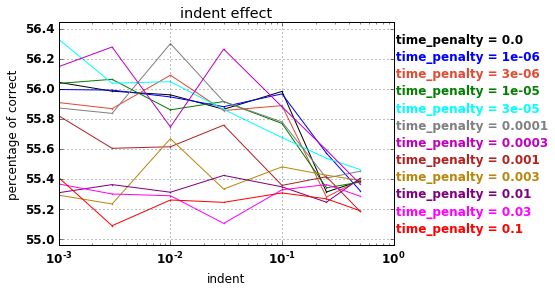

In [19]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_LSTM_plots.one_key_layout_data('ACT_LSTM_1',
                                         'indent',
                                                       'time_penalty')
ACT_LSTM_plots.save_layout(plot_data[0],
                    'indent effect',
                    ['plots'],
                    'idt_eff_nl1;nn128;ns20000;hl500;dc0.9',
                              plot_options=plot_options)
ACT_LSTM_plots.draw(plot_data[0], 'indent effect', plot_options=plot_options)

['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']
['init_shift', 'init_mean', 'batch_size', 'half_life', 'init_stddev', 'num_layers', 'num_unrollings', 'indent', 'decay', 'averaging_number', 'num_steps', 'num_nodes', 'depth', 'init_learning_rate', 'time_penalty', 'type']


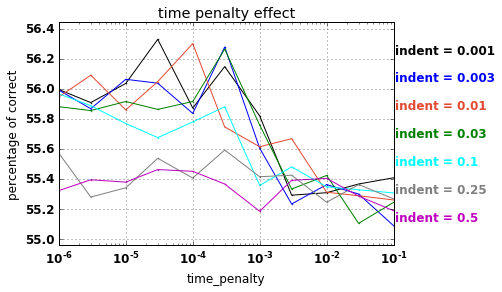

In [20]:
plot_options = {'x': 'log'}
plot_data, _ = ACT_LSTM_plots.one_key_layout_data('ACT_LSTM_1',
                                         'time_penalty',
                                                       'indent')
ACT_LSTM_plots.save_layout(plot_data[0],
                    'time penalty effect',
                    ['plots'],
                    'tp_eff_nl1;nn128;ns20000;hl500;dc0.9',
                           plot_options=plot_options)
ACT_LSTM_plots.draw(plot_data[0], 'time penalty effect', plot_options=plot_options)

In [11]:

num_unrollings_value = 20
indent_values = [.25, .03, .003, .0003]
time_penalty_values = [.1, .03, .01, 0.003, .001, 0.0003, 0.0001]

results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_LSTM(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text,
            init_learning_rate=10.)
        text_list, iter_list = model.run_for_analitics(model.get_iterations,
                                                        'ACT_LSTM/variables/nn128_dth_5_nu20_bs64_ilr10_hl500_ns20000/idt%s_tp%s' % (indent_value, time_penalty_value),
                                                        [300, 75, None])
        """check_text = ''
        check_text = check_text.join(text_list)
        count_words(check_text)"""

        structure_vocabulary_plots(text_list,
                                   iter_list,
                                   'iterations (indent: %s; time penalty: %s)' % (indent_value, time_penalty_value),
                                   'iterations',
                                   ['ACT_LSTM', 'iterations', 'vocabulary_plots'],
                                   'ns20k_idt%s_tp%s' % (indent_value, time_penalty_value),
                                   ylims = [1., 5.],
                                   ylims_fixed=True,
                                   show=False)
        for i in range(50):
            text_plot(text_list[i],
                      iter_list[i],
                      'iterations',
                      'iterations (indent: %s; time penalty: %s)' % (indent_value, time_penalty_value),
                      ['ACT_LSTM', 'text_plots', 'ns20k_nn128', 'idt%s_tp%s' % (indent_value, time_penalty_value)],
                      'ns20k_idt%s_tp%s#%s' % (indent_value, time_penalty_value, i),
                      ylims=[1., 5.],
                      show=False)
        model.destroy()
        del model
        gc.collect()

     indent:  0.25
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
     indent:  0.03
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
     indent:  0.003
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
     indent:  0.0003
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001


In [12]:
num_unrollings_value = 20
indent_values = [.5, .1, .01, .001]
time_penalty_values = [.1, .001, .00001, 0.]

results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_LSTM(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text,
            init_learning_rate=10.)
        text_list, iter_list = model.run_for_analitics(model.get_iterations,
                                                        'ACT_LSTM/variables/nn128_dth_5_nu20_bs64_ilr10_hl500_ns20000/idt%s_tp%s' % (indent_value, time_penalty_value),
                                                        [300, 75, None])
        """check_text = ''
        check_text = check_text.join(text_list)
        count_words(check_text)"""

        structure_vocabulary_plots(text_list,
                                   iter_list,
                                   'iterations (indent: %s; time penalty: %s)' % (indent_value, time_penalty_value),
                                   'iterations',
                                   ['ACT_LSTM', 'iterations', 'vocabulary_plots'],
                                   'ns20k_idt%s_tp%s' % (indent_value, time_penalty_value),
                                   ylims = [1., 5.],
                                   ylims_fixed=True,
                                   show=False)
        for i in range(50):
            text_plot(text_list[i],
                      iter_list[i],
                      'iterations',
                      'iterations (indent: %s; time penalty: %s)' % (indent_value, time_penalty_value),
                      ['ACT_LSTM', 'text_plots', 'ns20k_nn128', 'idt%s_tp%s' % (indent_value, time_penalty_value)],
                      'ns20k_idt%s_tp%s#%s' % (indent_value, time_penalty_value, i),
                      ylims=[1., 5.],
                      show=False)
        model.destroy()
        del model
        gc.collect()

     indent:  0.5
   time penalty:  0.1
   time penalty:  0.001
   time penalty:  1e-05
   time penalty:  0.0
     indent:  0.1
   time penalty:  0.1
   time penalty:  0.001
   time penalty:  1e-05
   time penalty:  0.0
     indent:  0.01
   time penalty:  0.1
   time penalty:  0.001
   time penalty:  1e-05
   time penalty:  0.0
     indent:  0.001
   time penalty:  0.1
   time penalty:  0.001
   time penalty:  1e-05
   time penalty:  0.0


In [22]:
short_results = dict()
for result in results_GL:
    if result['metadata'][model._indices['time_penalty']] not in short_results.keys():
        short_results[result['metadata'][model._indices['time_penalty']]] = dict()
        short_results[result['metadata'][model._indices['time_penalty']]][result['metadata'][model._indices['indent']]] = result['data']['train']['percentage'][-1]
    elif result['metadata'][model._indices['indent']] not in short_results[result['metadata'][model._indices['time_penalty']]].keys():
        short_results[result['metadata'][model._indices['time_penalty']]][result['metadata'][model._indices['indent']]] = result['data']['train']['percentage'][-1]
    else:
        print('Error! Skipping')
        print(result)

In [23]:
print(short_results.keys())

[0.0, 0.0003, 1e-06, 1e-05, 3e-06, 0.1, 0.001, 0.0001, 0.03, 0.003, 3e-05, 0.01]


In [24]:

num_unrollings_value = 20
indent_values = [.5, .25, .1, .03, .01, .003, .001]
time_penalty_values = [.1, .03, .01, 0.003, .001, 0.0003, 0.0001, .00003, .00001, .000003, .000001, .0]
results_GL = list()

for indent_value in indent_values:
    print(' '*4, "indent: ", indent_value)
    for time_penalty_value in time_penalty_values:
        print(' '*2, "time penalty: ", time_penalty_value)
        model = ACT_LSTM(64,
                                                vocabulary,
                                                characters_positions_in_vocabulary,
                                             num_unrollings_value,            #number of memory layers
                                             [128],
                    5,
                    indent_value,
                    time_penalty_value,
            train_text,
            valid_text)
        text_list, iter_list = model.run_for_analitics(model.get_iterations,
                                                        'ACT_LSTM/variables/nn128_dth_5_nu20_bs64_ilr5_hl1333_ns20000/idt%s_tp%s' % (indent_value, time_penalty_value),
                                                        [300, 75, None])

        structure_vocabulary_plots(text_list,
                                   iter_list,
                                   'iterations (indent: %s; time penalty: %s; result: %.2f%%)' % (indent_value, time_penalty_value, short_results[time_penalty_value][indent_value]),
                                   'iterations',
                                   ['ACT_LSTM', 'iterations', 'vocabulary_plots'],
                                   'ns20k_idt%s_tp%s' % (indent_value, time_penalty_value),
                                   ylims = [1., 5.],
                                   ylims_fixed=True,
                                   show=False)
        for i in range(50):
            text_plot(text_list[i],
                      iter_list[i],
                      'iterations',
                      'iterations (indent: %s; time penalty: %s; result: %.2f%%)' % (indent_value, time_penalty_value, short_results[time_penalty_value][indent_value]),
                      ['ACT_LSTM', 'text_plots', 'idt%s_tp%s_pcnt%.1f' % (indent_value, time_penalty_value, short_results[time_penalty_value][indent_value])],
                      'ns20k_idt%s_tp%s#%s' % (indent_value, time_penalty_value, i),
                      ylims=[1., 5.],
                      show=False)
        model.destroy()
        del model
        gc.collect()

     indent:  0.5
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
   time penalty:  3e-05
   time penalty:  1e-05
   time penalty:  3e-06
   time penalty:  1e-06
   time penalty:  0.0
     indent:  0.25
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
   time penalty:  3e-05
   time penalty:  1e-05
   time penalty:  3e-06
   time penalty:  1e-06
   time penalty:  0.0
     indent:  0.1
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   time penalty:  0.003
   time penalty:  0.001
   time penalty:  0.0003
   time penalty:  0.0001
   time penalty:  3e-05
   time penalty:  1e-05
   time penalty:  3e-06
   time penalty:  1e-06
   time penalty:  0.0
     indent:  0.03
   time penalty:  0.1
   time penalty:  0.03
   time penalty:  0.01
   tim